# **Practice Lab: Mountain Car with Function Approximation and Epsilon-Greedy**

## **Objective**

This project is designed to implement the **MountainCar-v0** environment in OpenAI Gym using **function approximation** and **epsilon-greedy exploration**. The code is broken down into various sections to make it easier to understand how Q-learning with function approximation works.

<img align="Left" src="https://www.gymlibrary.dev/_images/mountain_car.gif" width = 40% >

### MountainCar Environment

The **MountainCar** environment is a reinforcement learning problem where an underpowered car must reach the top of a hill. The agent needs to build momentum by moving back and forth between the hills since the car's engine is not strong enough to directly drive up the hill.

#### Key Components:

- **States**: The state is represented by two continuous variables:
  - **Position** ($x$): Between -1.2 and 0.6.
  - **Velocity** ($v$): Between -0.07 and 0.07.

- **Actions**: The agent can choose one of three actions:
  1. Move left (negative acceleration)
  2. Do nothing (zero acceleration)
  3. Move right (positive acceleration)

- **Rewards**:
  - **-1** at every timestep (penalty to encourage fast learning).
  - **+100** when the agent reaches the goal (position $x \geq 0.5$).

#### Objective:
The goal is for the agent to learn to drive the car to the top of the right hill by using the car's momentum effectively.


### Key Steps:
1. **Discretization**: Divide the continuous state space into bins for each state dimension (`position` and `velocity`).
2. **Linear Function Approximation**: Represent the Q-values using a parameterized linear model.
3. **Epsilon-Greedy Policy**: Use an exploration-exploitation strategy to select actions.
4. **Training Loop**: Update weights via the TD update rule.

---

## State and Action Overview
- **State Space**: Continuous `[position, velocity]` values are discretized.
- **Action Space**: `{0: left, 1: no push, 2: right}`.
- **Reward**: `-1` until the goal is reached.

## **Implementation Steps**

### 1. **Set Up Environment**

We first import the necessary libraries such as **NumPy**, **Gym**, and **matplotlib** for plotting. Then, we initialize the Mountain Car environment.
- `env.reset()` starts the environment, and `env.action_space` and `env.observation_space` give information about the action space and state space.

In [ ]:
# Importing required libraries
!pip install gym --upgrade
!wget https://raw.githubusercontent.com/kamenbliznashki/sutton_barto/refs/heads/master/tiles3.py

import numpy as np
import gym
import matplotlib.pyplot as plt
import tiles3 as tc
import time
import imageio

# Environment Setup
env = gym.make("MountainCar-v0")

# Environment details
print("Observation Space:", env.observation_space)  # State space (position, velocity)
print("Action Space:", env.action_space)            # Action space (left, no action, right)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827628 sha256=c4e3d44c2f75252a3d50fbec06367d5f55c49b4ff9fd5e6273e6e0f1e77f9ebc
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.9 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.
--2024-12-11 10:11:00--  https://raw.githubusercontent.com/kamenbliznashki/sutton_barto/refs/heads/mas

In [ ]:
# Define argmax function
def argmax(q_values):
    top = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = []

        if q_values[i] == top:
            ties.append(i)

    return np.random.choice(ties)

### 2. **Discretization of State Space Using Tile Coding Function**

Tile coding is introduced in [Section 9.5.4 of the textbook](http://www.incompleteideas.net/book/RLbook2018.pdf#page=239) of the textbook as a way to create features that can both provide good generalization and discrimination. It consists of multiple overlapping tilings, where each tiling is a partitioning of the space into tiles.


<img align="Left" src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*AZXJ9lWBReLEcEQDt0_jpQ.jpeg" width = 80% >



To maintain a clean structure in our agent code, we'll create a function dedicated to tile coding for the Mountain Car environment. We'll leverage the Tiles3 library, which is a Python 3 implementation of the tile coder. To get started, take a look at the official documentation: [Tiles3 documentation](http://incompleteideas.net/tiles/tiles3.html).

To set up the tile coder, we'll need to implement the following steps:

Create an index hash table: This step is handled for you in the __init__ function using tc.IHT.
Scale the inputs: The inputs need to be scaled for the tile coder according to the number of tiles and the range of possible input values. The tile coder expects values in the range [0, 1], or scaled to [0, 1] * num_tiles. For more details, refer to the [Tiles3 documentation](http://incompleteideas.net/tiles/tiles3.html).
Get active tiles: Finally, we use tc.tiles to retrieve the active tiles.

### The Principle of Tile Coding

Tile coding is a method for representing continuous state spaces in the context of reinforcement learning. It transforms real-valued state spaces (e.g., the position and velocity of a car in the Mountain Car environment) into a rich, discrete feature representation. Here's how it works:

---

#### 1. **Continuous State Space**
Imagine a continuous state space, such as the position and velocity of a vehicle on a slope. These values are often real numbers. However, many reinforcement learning methods, especially value function-based approaches, are simpler to implement if states are represented as discrete feature vectors or have specific indices assigned to them.

---

#### 2. **Tiling the Domain**
To transform this continuous space into discrete features, the domain is divided into a grid of "tiles." Each tile acts as a small cell or rectangle (in 2D) that covers part of the space. For instance, if the space is defined by position (`x`) and velocity (`v`), you could create a regular grid where each tile corresponds to an interval of position and velocity.

---

#### 3. **Multiple Offset Grids (Tilings)**
A single grid wouldn't provide a representation that is both fine-grained and flexible. Therefore, multiple grids, or "tilings," are used, each slightly offset or scaled differently. This ensures that for a given state (position and velocity), several tiles from different grids are activated simultaneously. Each tile can be thought of as a binary feature (active or not).

   - **Example**: Imagine 4 grids:
     - The first grid is aligned normally.
     - The second grid is slightly shifted.
     - The third grid has a different offset, and so on.
     For a specific state, one tile from each grid will be active, resulting in multiple features representing the state.

---

#### 4. **Features and Generalization**
This process transforms each state into a set of features (the active tiles). This encoding provides two main advantages:
   - **Generalization**: Nearby states in the continuous space share similar active tiles, facilitating the generalization of value estimates or policies.
   - **Discrimination**: By using multiple overlapping grids, the representation is more detailed than a single grid. Slightly different states activate different tiles in some grids, enabling better distinction and more precise learning.

---

#### 5. **Usage in Reinforcement Learning**
Tile coding is often used with control methods such as Sarsa, Q-learning, or linear function approximation techniques. The activated tiles serve as input features for an approximated value function, allowing efficient estimation of state-action values.

---

### **Summary**
Tile coding is an intelligent discretization method for continuous state spaces. By employing multiple overlapping grids (tilings), each with its set of tiles, and combining the activated tiles, it provides a robust, flexible representation tailored to reinforcement learning. This approach enables:
- **Better Generalization**: Similar states share features.
- **Precise Discrimination**: Slightly different states can be distinguished using multiple tilings.

It’s a practical and widely used technique for efficiently approximating value functions and policies in reinforcement learning.

In [ ]:
# Tile Coding Function [Graded]
class MountainCarTileCoder:
    def __init__(self, iht_size=4096, num_tilings=8, num_tiles=8):
        """
        Initializes the MountainCar Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the
                     tile coder are the same
        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """
        self.iht = tc.IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles

    def get_tiles(self, position, velocity):
        """
        Takes in a position and velocity from the mountaincar environment
        and returns a numpy array of active tiles.

        Arguments:
        position -- float, the position of the agent between -1.2 and 0.5
        velocity -- float, the velocity of the agent between -0.07 and 0.07
        returns:
        tiles - np.array, active tiles
        """
        # Set the max and min of position and velocity to scale the input
        # POSITION_MIN
        # POSITION_MAX
        # VELOCITY_MIN
        # VELOCITY_MAX
        ### START CODE HERE ###
        POSITION_MIN = -1.2
        POSITION_MAX = 0.5
        VELOCITY_MIN = -0.07
        VELOCITY_MAX = 0.07
        ### END CODE HERE ###

        # Use the ranges above and self.num_tiles to set position_scale and velocity_scale
        # position_scale = number of tiles / position range
        # velocity_scale = number of tiles / velocity range

        # Scale position and velocity by multiplying the inputs of each by their scale

        ### START CODE HERE ###
        position_scale = self.num_tiles / (POSITION_MAX - POSITION_MIN)
        velocity_scale = self.num_tiles / (VELOCITY_MAX - VELOCITY_MIN)
        ### END CODE HERE ###

        # get the tiles using tc.tiles, with self.iht, self.num_tilings and [scaled position, scaled velocity]
        # nothing to implment here
        tiles = tc.tiles(self.iht, self.num_tilings, [position * position_scale,
                                                      velocity * velocity_scale])

        return np.array(tiles)

In [ ]:
# Test Tile Coding [DO NOT CHANGE]
tests = [[-1.0, 0.01], [0.1, -0.01], [0.2, -0.05], [-1.0, 0.011], [0.2, -0.05]]

mctc = MountainCarTileCoder(iht_size=1024, num_tilings=8, num_tiles=8)

t = []
for test in tests:
    position, velocity = test
    tiles = mctc.get_tiles(position=position, velocity=velocity)
    t.append(tiles)

print("Your results:")
for tiles in t:
    print(tiles)

print()
print("Expected results:")
expected = """[0 1 2 3 4 5 6 7]
[ 8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23]
[ 0 24  2  3  4  5  6  7]
[16 17 18 19 20 21 22 23]
"""
print(expected)

np.random.seed(1)
mctc_test = MountainCarTileCoder(iht_size=1024, num_tilings=8, num_tiles=8)
test = [mctc_test.get_tiles(np.random.uniform(-1.2, 0.5), np.random.uniform(-0.07, 0.07)) for _ in range(10)]

Your results:
[0 1 2 3 4 5 6 7]
[ 8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23]
[ 0 24  2  3  4  5  6  7]
[16 17 18 19 20 21 22 23]

Expected results:
[0 1 2 3 4 5 6 7]
[ 8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23]
[ 0 24  2  3  4  5  6  7]
[16 17 18 19 20 21 22 23]



In [ ]:
# Clear all GIFs in the current directory

import os
# Get the current working directory
current_directory = os.getcwd()

# List all files in the directory
files_in_directory = os.listdir(current_directory)

# Loop through the files and delete .gif files
for file in files_in_directory:
    if file.endswith(".gif"):
        file_path = os.path.join(current_directory, file)
        try:
            os.remove(file_path)
            print(f"Deleted: {file}")
        except Exception as e:
            print(f"Could not delete {file}: {e}")

print("All .gif files deleted (if any were found).")

All .gif files deleted (if any were found).


### 3. **Sarsa Function Approximator**

**SARSA Algorithm**

SARSA updates the action-value function $Q(s, a)$ as:

$Q(s, a) \leftarrow Q(s, a) + \alpha \left( r + \gamma Q(s', a') - Q(s, a) \right)$

With function approximation, $Q(s, a)$ is expressed as:

$Q(s, a) = \mathbf{w}[a] \cdot \phi(s, a)$

Where $\phi(s, a)$ are the features (active tiles).

---

**Tile Coding**

1. **Generate Features**: `self.tc.get_tiles(position, velocity)` maps continuous states to discrete tiles.
2. **Weight Update**:
   $$
   \mathbf{w}[a, \text{tile}] \leftarrow \mathbf{w}[a, \text{tile}] + \alpha \delta
   $$
   With:
   $$
   \delta = r + \gamma Q(s', a') - Q(s, a)
   $$

---

**Key Functions**

1. **`agent_step`**:
   - Updates $\mathbf{w}$ for active tiles based on the TD error:
   
   $$\delta = r + \gamma Q(s', a') - Q(s, a)$$

2. **`agent_end`**:
   - Updates weights for the terminal state:
     $$
     \delta = r - Q(s, a)
     $$

3. **`select_action`**:
   - Implements **epsilon-greedy** action selection.


In [ ]:
# SARSA
class SarsaAgent:
    """
    Initialization of Sarsa Agent. All values are set to None so they can
    be initialized in the agent_init method.
    """
    def __init__(self):
        self.last_action = None
        self.last_state = None
        self.epsilon = None
        self.gamma = None
        self.iht_size = None
        self.w = None
        self.alpha = None
        self.num_tilings = None
        self.num_tiles = None
        self.mctc = None
        self.initial_weights = None
        self.num_actions = None
        self.previous_tiles = None

    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts."""
        self.num_tilings = agent_info.get("num_tilings", 8)
        self.num_tiles = agent_info.get("num_tiles", 8)
        self.iht_size = agent_info.get("iht_size", 4096)
        self.epsilon = agent_info.get("epsilon", 0.0)
        self.gamma = agent_info.get("gamma", 1.0)
        self.alpha = agent_info.get("alpha", 0.5) / self.num_tilings
        self.initial_weights = agent_info.get("initial_weights", 0.0)
        self.num_actions = agent_info.get("num_actions", 3)

        # We initialize self.w to three times the iht_size. Recall this is because
        # we need to have one set of weights for each action.
        self.w = np.ones((self.num_actions, self.iht_size)) * self.initial_weights

        # We initialize self.mctc to the mountaincar verions of the
        # tile coder that we created
        self.tc = MountainCarTileCoder(iht_size=self.iht_size,
                                         num_tilings=self.num_tilings,
                                         num_tiles=self.num_tiles)

    def select_action(self, tiles):
        """
        Selects an action using epsilon greedy
        Args:
        tiles - np.array, an array of active tiles
        Returns:
        (chosen_action, action_value) - (int, float), tuple of the chosen action
                                        and it's value
        """
        action_values = []
        chosen_action = None

        # First loop through the weights of each action and populate action_values
        # with the action value for each action and tiles instance

        # Use np.random.random to decide if an exploritory action should be taken
        # and set chosen_action to a random action if it is
        # Otherwise choose the greedy action using the given argmax
        # function and the action values (don't use numpy's armax)

        ### START CODE HERE ###
        action_values = np.zeros(self.num_actions)
        for action in range(self.num_actions):
            action_values[action] = np.sum(self.w[action][tiles])

        if np.random.random() < self.epsilon:
            chosen_action = np.random.randint(0, self.num_actions)
        else:
            chosen_action = argmax(action_values)
        ### END CODE HERE ###

        return chosen_action, action_values[chosen_action]

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state observation from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        position, velocity = state

        # Use self.tc to set active_tiles using position and velocity
        # set current_action to the epsilon greedy chosen action using
        # the select_action function above with the active tiles

        ### START CODE HERE ###
        active_tiles = self.tc.get_tiles(position, velocity)
        current_action, action_value = self.select_action(active_tiles)
        ### END CODE HERE ###

        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        # choose the action here
        position, velocity = state

        # Use self.tc to set active_tiles using position and velocity
        # set current_action and action_value to the epsilon greedy chosen action using
        # the select_action function above with the active tiles

        # Update self.w at self.previous_tiles and self.previous action
        # using the reward, action_value, self.gamma, self.w,
        # self.alpha, and the Sarsa update from the textbook

        ### START CODE HERE ###
        active_tiles = self.tc.get_tiles(position, velocity)
        current_action, action_value = self.select_action(active_tiles)

        last_action_value = np.sum(self.w[self.last_action][self.previous_tiles])
        self.w[self.last_action][self.previous_tiles] += self.alpha * (reward + self.gamma * action_value - last_action_value) * 1
        ### END CODE HERE ###

        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Update self.w at self.previous_tiles and self.previous action
        # using the reward, self.gamma, self.w,
        # self.alpha, and the Sarsa update from the textbook
        # Hint - there is no action_value used here because this is the end
        # of the episode.

        ### START CODE HERE ###
        last_action_value = np.sum(self.w[self.last_action][self.previous_tiles])
        self.w[self.last_action][self.previous_tiles] += self.alpha * (reward - last_action_value) * 1
        ### END CODE HERE ###

    def agent_cleanup(self):
        """Cleanup done after the agent ends."""
        pass

    def agent_message(self, message):
        """A function used to pass information from the agent to the experiment.
        Args:
            message: The message passed to the agent.
        Returns:
            The response (or answer) to the message.
        """
        pass

In [ ]:
# Test Epsilon Greedy Function [DO NOT CHANGE]
agent = SarsaAgent()
agent.agent_init({"epsilon": 0.1})
agent.w = np.array([np.array([1, 2, 3]), np.array([4, 5, 6]), np.array([7, 8, 9])])

total = 0
for i in range(1000):
    chosen_action, action_value = agent.select_action(np.array([0,1]))
    total += action_value
print(total)
assert total < 15000, "Check that you are not always choosing the best action"

np.save("epsilon_test", total)

agent = SarsaAgent()
agent.agent_init({"epsilon": 0.0})
agent.w = np.array([np.array([1, 2, 3]), np.array([4, 5, 6]), np.array([7, 8, 9])])

chosen_action, action_value = agent.select_action(np.array([0,1]))
print("Expected value")
print("(2, 15)")

print("Your value")
print((chosen_action, action_value))

14460.0
Expected value
(2, 15)
Your value
(2, 15.0)


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
Run time: 110.33531403541565


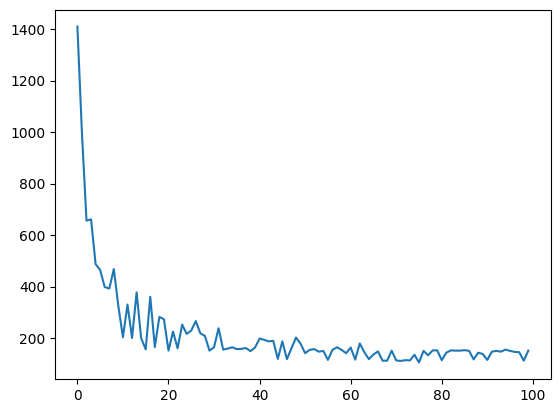

In [ ]:
# Test Sarsa Agent [DO NOT CHANGE]

num_episodes = 100
MAX_NB_STEPS = 15000
SHOW_EVERY = 10
env_info = {"num_tiles": 8, "num_tilings": 8}
agent_info = {}
all_steps = []
n_total_episodes = 0

agent = SarsaAgent()
agent.agent_init()

env = gym.make("MountainCar-v0", render_mode='rgb_array')
from gym.wrappers import TimeLimit
env = TimeLimit(env, max_episode_steps=MAX_NB_STEPS)
start = time.time()

num_steps = 0
steps_per_episode = []
rewards = []

for episode in range(num_episodes):
    if episode % SHOW_EVERY == 0:
        render = True
    else:
        render = False

    frames = []
    done = False

    total_reward = 0.0
    num_steps = 1
    last_state, _ = env.reset()  # Extract the state from reset()
    last_action = agent.agent_start(last_state)

    while not done:
        last_state, reward, done, _, _ = env.step(last_action)
        total_reward += reward

        if render:
            frames.append(env.render())

        if done:
            agent.agent_end(reward)
        else:
            num_steps += 1
            last_action = agent.agent_step(reward, last_state)

    steps_per_episode.append(num_steps)

    if render:
        print(frames[0].shape)
        imageio.mimsave(f'./sarsa_{episode}.gif', frames, fps=40)

env.close()

all_steps.append(np.array(steps_per_episode))

print("Run time: {}".format(time.time() - start))

plt.plot(np.mean(np.array(all_steps), axis=0))

### 4. **Q-Learning Function Approximator**

**Q-Learning Algorithm**

Q-Learning updates the action-value function $Q(s, a)$ as:

$Q(s, a) \leftarrow Q(s, a) + \alpha \left( r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right)$

With function approximation, $Q(s, a)$ is expressed as:

$Q(s, a) = \mathbf{w}[a] \cdot \phi(s, a)$

Where $\phi(s, a)$ are the features (active tiles).

---

**Tile Coding**

1. **Generate Features**: `self.tc.get_tiles(position, velocity)` maps continuous states to discrete tiles.
2. **Weight Update**:
   $$
   \mathbf{w}[a, \text{tile}] \leftarrow \mathbf{w}[a, \text{tile}] + \alpha \delta
   $$
   With:
   $$
   \delta = r + \gamma \max_{a'} Q(s', a') - Q(s, a)
   $$

---

**Key Functions**

1. **`agent_step`**:
   - Updates $\mathbf{w}$ for active tiles based on the TD error:
   $$\delta = r + \gamma \max_{a'} Q(s', a') - Q(s, a)$$

2. **`agent_end`**:
   - Updates weights for the terminal state:
     $$
     \delta = r - Q(s, a)
     $$

3. **`select_action`**:
   - Implements **epsilon-greedy** action selection.



In [ ]:
class QLearningAgent:
    """
    Q-Learning Agent implementation similar to the SARSA agent.
    """
    def __init__(self):
        self.last_state = None
        self.epsilon = None
        self.gamma = None
        self.iht_size = None
        self.w = None
        self.alpha = None
        self.num_tilings = None
        self.num_tiles = None
        self.tc = None
        self.num_actions = None

    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts."""
        self.num_tilings = agent_info.get("num_tilings", 8)
        self.num_tiles = agent_info.get("num_tiles", 8)
        self.iht_size = agent_info.get("iht_size", 4096)
        self.epsilon = agent_info.get("epsilon", 0.1)
        self.gamma = agent_info.get("gamma", 1.0)
        self.alpha = agent_info.get("alpha", 0.5) / self.num_tilings
        self.num_actions = agent_info.get("num_actions", 3)

        # Initialize weights for Q-learning
        self.w = np.ones((self.num_actions, self.iht_size)) * agent_info.get("initial_weights", 0.0)

        # Mountain Car Tile Coder
        self.tc = MountainCarTileCoder(
            iht_size=self.iht_size,
            num_tilings=self.num_tilings,
            num_tiles=self.num_tiles
        )

    def select_action(self, tiles):
        """
        Select an action using epsilon-greedy policy.
        """
        action_values = np.zeros(self.num_actions)
        for action in range(self.num_actions):
            action_values[action] = np.sum(self.w[action][tiles])

        if np.random.random() < self.epsilon:
            chosen_action = np.random.randint(0, self.num_actions)  # Explore
        else:
            chosen_action = argmax(action_values)  # Exploit

        return chosen_action, action_values[chosen_action]

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state observation from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        position, velocity = state

        # Use self.tc to set active_tiles using position and velocity
        # set current_action to the epsilon greedy chosen action using
        # the select_action function above with the active tiles

        ### START CODE HERE ###
        active_tiles = self.tc.get_tiles(position, velocity)
        current_action, action_value = self.select_action(active_tiles)
        ### END CODE HERE ###

        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent."""
        position, velocity = state
        active_tiles = self.tc.get_tiles(position, velocity)

        # Choose the best action for the next state (Q-Learning)
        q_values_next = np.array([np.sum(self.w[a][active_tiles]) for a in range(self.num_actions)])
        max_q_value_next = np.max(q_values_next)

        # Update weights using Q-Learning update rule
        q_current = np.sum(self.w[self.last_action][self.last_state])
        self.w[self.last_action][self.last_state] += self.alpha * (reward + self.gamma * max_q_value_next - q_current)

        # Choose the next action using epsilon-greedy
        next_action, action_value = self.select_action(active_tiles)

        # Update last state and action
        self.last_state = active_tiles
        self.last_action = next_action

        return next_action

    def agent_end(self, reward):
        """Run when the agent terminates."""
        # Update the weights for the terminal state
        q_current = np.sum(self.w[self.last_action][self.last_state])
        self.w[self.last_action][self.last_state] += self.alpha * (reward - q_current)

    def agent_cleanup(self):
        """Cleanup done after the agent ends."""
        pass

    def agent_message(self, message):
        """A function used to pass information from the agent to the experiment."""
        pass


In [ ]:
# Test Epsilon Greedy Function [DO NOT CHANGE]
agent = QLearningAgent()
agent.agent_init({"epsilon": 0.1})
agent.w = np.array([np.array([1, 2, 3]), np.array([4, 5, 6]), np.array([7, 8, 9])])

total = 0
for i in range(1000):
    chosen_action, action_value = agent.select_action(np.array([0,1]))
    total += action_value
print(total)
assert total < 15000, "Check that you are not always choosing the best action"

np.save("epsilon_test", total)

agent = QLearningAgent()
agent.agent_init({"epsilon": 0.0})
agent.w = np.array([np.array([1, 2, 3]), np.array([4, 5, 6]), np.array([7, 8, 9])])

chosen_action, action_value = agent.select_action(np.array([0,1]))
print("Expected value")
print("(2, 15)")

print("Your value")
print((chosen_action, action_value))

14532.0
Expected value
(2, 15)
Your value
(2, 15.0)


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
(400, 600, 3)
Run time: 127.09159970283508


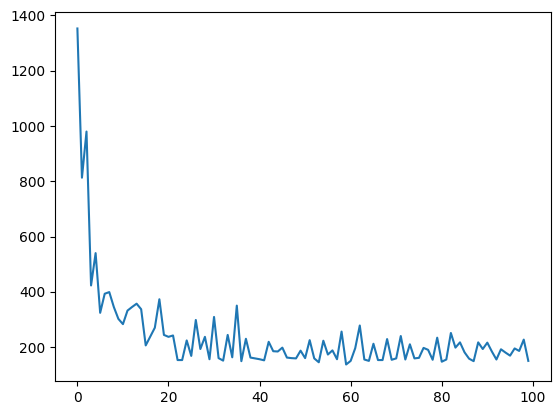

In [ ]:
# Test Q-Learning Agent [DO NOT CHANGE]
num_episodes = 100
MAX_NB_STEPS = 15000
SHOW_EVERY = 10
env_info = {"num_tiles": 8, "num_tilings": 8}
agent_info = {}
all_steps = []
n_total_episodes = 0

agent = QLearningAgent()
agent.agent_init()

env = gym.make("MountainCar-v0", render_mode='rgb_array')
from gym.wrappers import TimeLimit
env = TimeLimit(env, max_episode_steps=MAX_NB_STEPS)
start = time.time()

num_steps = 0
steps_per_episode = []
rewards = []

for episode in range(num_episodes):
    if episode % SHOW_EVERY == 0:
        render = True
    else:
        render = False

    frames = []
    done = False

    total_reward = 0.0
    num_steps = 1
    last_state, _ = env.reset()  # Extract the state from reset()
    last_action = agent.agent_start(last_state)

    while not done:
        last_state, reward, done, _, _ = env.step(last_action)
        total_reward += reward

        if render:
            frames.append(env.render())

        if done:
            agent.agent_end(reward)
        else:
            num_steps += 1
            last_action = agent.agent_step(reward, last_state)

    steps_per_episode.append(num_steps)

    if render:
        print(frames[0].shape)
        imageio.mimsave(f'./qlearning_{episode}.gif', frames, fps=40)

env.close()

all_steps.append(np.array(steps_per_episode))

print("Run time: {}".format(time.time() - start))

plt.plot(np.mean(np.array(all_steps), axis=0))

Last saved episode: 90, showing result


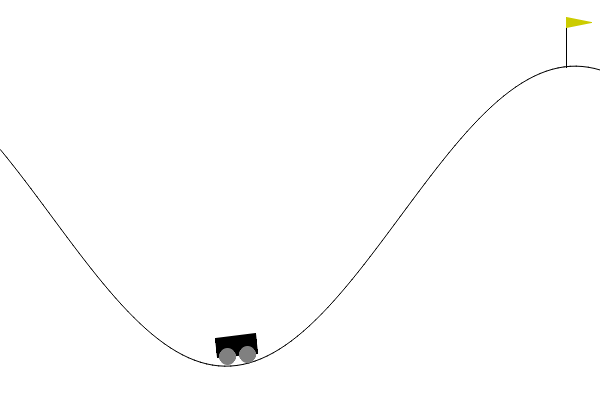

In [ ]:
# plot last saved gif
last_eps = (num_episodes - 1)
last_eps = last_eps if last_eps % SHOW_EVERY == 0 else last_eps - (last_eps % SHOW_EVERY)
print(f"Last saved episode: {last_eps}, showing result")
from IPython.display import Image
Image(filename=f'./qlearning_{last_eps}.gif')
